# spectra: drifter and numerical simulation

In [4]:
import os
from glob import glob
import threading

import numpy as np
import dask.dataframe as dd
from dask import delayed
import pandas as pd
import xarray as xr

%matplotlib inline
from matplotlib import pyplot as plt
#import matplotlib.animation as anima

import crocosi.postp as pp
from crocosi.jet import set_relevant_time

In [2]:
from dask_jobqueue import PBSCluster
cluster = PBSCluster()
w = cluster.scale(28*2)

In [3]:
from dask.distributed import Client
#client = Client()  # set up local cluster on your laptop
client = Client(cluster) # with distributed cluster

In [23]:
client

Client Scheduler: tcp://10.148.1.47:53795 Dashboard: http://10.148.1.47:8787/status,Cluster Workers: 56 Cores: 56 Memory: 240.24 GB


---

## load data

In [7]:
root_path = '/home/datawork-lops-osi/slgentil/croco/jetn/'
#root_path = '/home1/datawork/slgentil/'#jet_cfg1_wp75_4km_1500a2000j_floats_lev50
run = 'jet_cfg1_wp75_4km_1500a2000j_floats_lev50_itide/'

# !!!
L=1026 # check this parameter, corresponds to the x period 

In [8]:
# should create a method to get default bins

In [24]:
class drifter_dataframe(object):
    
    def __init__(self, run_path, tdir_max=0, persist=True):
        if tdir_max==0:
            t='t?'
        else:
            t='t[1-%d]'%tdir_max
        df = dd.read_csv(glob(run_path+t+'/float.????'), 
                 names=['id','time','xgrid','ygrid','zgrid',
                        'depth','temp',
                        'u','v','dudt','dvdt',
                        'pres'],
                 delim_whitespace=True)
        dxy = int(run_path[run_path.find('km')-1])
        df['x'] = df.xgrid*dxy
        df['y'] = df.ygrid*dxy
        if persist:
            df = df.persist()
        self.df = df
            
    def __repr__(self):
        return str(self.df.head())
        
    def init_bins(self,**kwargs):
        """
        dr.init_bins(y={'min': 0., 'max': 2800., 'step': 10}, x=...)
        """
        idx = {}
        for key, item in kwargs.items():
            bins = np.arange(item['min'],item['max'], item['step'])
            idx[key] = pd.IntervalIndex.from_breaks(bins)
            self.df[key+'_cut'] = self.df[key].map_partitions(pd.cut, bins=bins)
        self.idx = idx
        
    def get_stats(self, V, stats, vbin):
        if isinstance(V, str):
            _V = [V]
        else:
            _V = V
            
        S = []
        for v in _V:
            _ds = (self.df.groupby([vb+'_cut' for vb in vbin])[v].agg(stats)
                 .compute().to_xarray().rename({s: v+'_'+s for s in stats}) #pandas
                )
            S.append(_ds)

        return xr.merge(S).assign_coords(**{vb+'_bins': self.idx[vb].mid for vb in vbin})


In [25]:
dr = drifter_dataframe(root_path+run, tdir_max=1)

In [26]:
dr

     id       time      xgrid      ygrid  zgrid     depth       temp  \
0  7161  1500.0069  196.40944  541.79652   50.0 -0.935944  25.886666   
1  7162  1500.0069  196.40937  543.30184   50.0 -0.940022  25.885229   
2  7163  1500.0069  196.40946  544.80716   50.0 -0.944117  25.884374   
3  7164  1500.0069  196.40961  546.31250   50.0 -0.948345  25.884627   
4  7165  1500.0069  196.40971  547.81780   50.0 -0.952706  25.885603   

          u         v          dudt          dvdt      pres          x  \
0  0.058079 -0.105506 -5.820925e-08  3.420817e-07 -8.260263  785.63776   
1  0.057283 -0.101750 -2.034746e-08  3.515808e-07 -8.300321  785.63748   
2  0.058512 -0.097537 -1.201106e-09  3.599363e-07 -8.340519  785.63784   
3  0.060480 -0.093268 -1.958836e-08  3.627984e-07 -8.381996  785.63844   
4  0.061626 -0.089432 -6.096121e-08  3.575484e-07 -8.424740  785.63884   

            y  
0  2167.18608  
1  2173.20736  
2  2179.22864  
3  2185.25000  
4  2191.27120  

---

## compute lagged autocorrelations

In [27]:
df = dr.df.groupby(['id']).get_group(225).compute()
df

,id,time,xgrid,ygrid,zgrid,depth,temp,u,v,dudt,dvdt,pres,x,y
214868,225,1570.8264,64.540791,506.31536,50.0,-0.253142,25.732828,0.202881,0.033091,0.000018,-0.000011,-1.567594,258.163164,2025.26144
215194,225,1570.8333,64.574002,506.32280,50.0,-0.257412,25.733086,0.214414,0.026651,0.000018,-0.000012,-1.609474,258.296008,2025.29120
215520,225,1570.8403,64.608910,506.32926,50.0,-0.261714,25.733342,0.225893,0.019492,0.000018,-0.000013,-1.651677,258.435640,2025.31704
215846,225,1570.8472,64.645473,506.33459,50.0,-0.265970,25.733592,0.237231,0.011717,0.000017,-0.000014,-1.693422,258.581892,2025.33836
216172,225,1570.8542,64.683638,506.33865,50.0,-0.270151,25.733832,0.248327,0.003399,0.000017,-0.000014,-1.734430,258.734552,2025.35460
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108793,225,1541.4514,256.294310,510.08467,50.0,-0.245975,25.696389,0.278416,0.210083,0.000026,-0.000017,-1.055925,1025.177240,2040.33868
109107,225,1541.4583,256.337050,510.11575,50.0,-0.246787,25.696408,0.292374,0.199391,0.000025,-0.000020,-0.996575,1025.348200,2040.46300
109422,225,1541.4653,256.381960,510.14518,50.0,-0.247642,25.696447,0.305899,0.187367,0.000024,-0.000022,-0.933588,1025.527840,2040.58072
109738,225,1541.4722,256.428980,510.17277,50.0,-0.248573,25.696506,0.318877,0.174068,0.000023,-0.000024,-0.867171,1025.715920,2040.69108


In [28]:
def mean_position(df, L):
    """ compute the mean position, accounts for the wrapping of x
    """
    x = (np.angle(
            np.exp(1j*(df['x']*2.*np.pi/L-np.pi)).mean()
                 ) + np.pi
        )*L/2./np.pi
    _x = df['x'].mean()
    y = df['y'].mean()
    return x, y

mean_position(df, L)

(104.19882827429669, 1931.0729616583335)

In [29]:
# assumes regular time intervals
def chunk_processing(df, T, overlap):
    p = df.sort_values('time').set_index('time')
    tmin, tmax, dt = p.index[0], p.index[-1], p.index[1] - p.index[0]
    #
    out = [pd.DataFrame({'lag': [], 'x' : [], 'y': []})]
    t=tmin
    while t+T<tmax:
        #
        # should not consider segments with not enough data points
        _p = p.loc[t:t+T]
        # compute average position
        x, y = mean_position(_p, L)
        # autocrrelation:
        # todo (?): detrend?
        _u = np.correlate(p['u'], p['u'], mode='same')
        N = _u.size
        _u = _u[int(N/2):]
        #out += [{'u_autoc': _u, 'x': x, 'y': y}]
        _out = pd.DataFrame([[x,y,_] for _ in _u], columns = ['x', 'y', 'uu'], 
                            index=np.arange(N/2)*dt)
        _out = _out.reset_index().rename(columns={'index':'lag'})
        out.append(_out)
        t+=T*(1-overlap)
    return pd.concat(out)

In [30]:
out = chunk_processing(df, 10., .5)
out

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.7/site-packages/ipykernel_launcher.py:25: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



,lag,uu,x,y
0,0.000,490.294558,52.092162,1939.403586
1,0.007,489.475840,52.092162,1939.403586
2,0.014,487.187966,52.092162,1939.403586
3,0.021,483.451739,52.092162,1939.403586
4,0.028,478.301506,52.092162,1939.403586
...,...,...,...,...
7195,50.365,59.199439,323.037921,1818.808152
7196,50.372,59.595464,323.037921,1818.808152
7197,50.379,59.888427,323.037921,1818.808152
7198,50.386,60.076758,323.037921,1818.808152


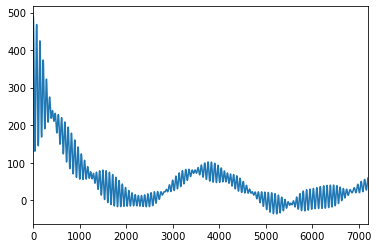

In [31]:
out.groupby('x').get_group(out['x'].unique()[0])['uu'].plot(x='lag')

In [32]:
df_chunked = (dr.df.groupby(['id']).apply(chunk_processing, 10., .5, 
                                          meta={k: 'f8' for k in ['lag','uu','x','y']})
              #.persist() # leads to a very long shuffle
             )
df_chunked

,lag,uu,x,y
npartitions=404,,,,
,float64,float64,float64,float64
,...,...,...,...
...,...,...,...,...
,...,...,...,...
,...,...,...,...


,lag,x,y
npartitions=404,,,
,float64,float64,float64
,...,...,...
...,...,...,...
,...,...,...
,...,...,...


In [33]:
y_bins = np.arange(0,2800,50)
y_idx = pd.IntervalIndex.from_breaks(y_bins)
df_chunked['y_cut'] = df_chunked['y'].map_partitions(pd.cut, bins=y_bins)
uu = df_chunked.groupby(['y_cut'])['uu'].sum().compute().to_xarray() #.rename({s: v+'_'+s for s in stats}

KeyboardInterrupt: 

---
## compute spectra

In [ ]:
def chunk_processing(p, T, overlap):
    tmin, tmax = p['time'][0], p['time'][-1]
    t=tmin
    # interpolate small gaps
    #p0 = p0[~pd.isnull(p0.index)].resample('H').interpolate('linear', limit=24)
    #
    flag=False
    out = []
    while t+dt<tmax:
        #
        # should not consider segments with not enough data points
        lp = p0.loc[t:t+dt]
        # compute average position
        lp = p0.loc[t:t+dt]
        for band in filters:
            lp = lp.join(p_filt[band]['p'].loc[t:t+dt])
        out += [{'df': lp, 'ID': '%d'%(ID), 't0': t}]
        t+=dt*(1-overlap)
    if flag:
        out = None
    return out

In [ ]:
def _get_E(x, method, ufunc=True, **kwargs):
    if method=='welch':
        ax = -1 if ufunc else 0
        ax = -1
        dkwargs = {'window': 'hann', 'return_onesided': False, 
                   'detrend': 'linear', 'scaling': 'density'}
        dkwargs.update(kwargs)
        f, E = signal.periodogram(x, fs=24., axis=ax, **dkwargs)
    elif method=='mtspec':
        E = []
        for i in range(x.shape[0]):
                lE, f = mtspec(data=x[i,:], delta=1/24., time_bandwidth=4.,
                               number_of_tapers=6, quadratic=True)
                E+=[lE[None,:]]
        E = np.concatenate(E,axis=0)
    elif method=='mt':
        lf, E, nu = tsa.multi_taper_psd(x, Fs=24., NW=2, sides='twosided',
                                       adaptive=False, jackknife=False)
        f = fftfreq(len(lf))*24.
        # http://nipy.org/nitime/examples/multi_taper_spectral_estimation.html
        #print('Number of tapers = %d' %(nu[0]/2))
    #
    if ufunc:
        return E
    else:
        return f, E

def get_E(v, f=None, **kwargs):
    Nb = len(v.TIME)
    dkwargs = {'method': 'welch'}
    dkwargs.update(kwargs)
    if dkwargs['method']=='mtspec':
        Nb = 361
    if f is None:
        f, E = _get_E(v.values, ufunc=False, **dkwargs)
        return f, E
    else:
        E = xr.apply_ufunc(_get_E, v,
                    dask='parallelized', output_dtypes=[np.float64],
                    input_core_dims=[['TIME']],
                    output_core_dims=[['freq_time']],
                    output_sizes={'freq_time': Nb}, kwargs=dkwargs)
        return E.assign_coords(freq_time=f).sortby('freq_time')